In [1]:
import pandas as pd

In [2]:
class Minigraph:
    def __init__(self):
        self.weights_of_edges = dict()
        self.codes = dict()
        self.codes_inv = list()
    
    def add_edge(self, fr: str, to: str):
        if fr not in self.codes:
            self.codes[fr] = len(self.codes)
            self.codes_inv.append(fr)
        if to not in self.codes:
            self.codes[to] = len(self.codes)
            self.codes_inv.append(to)
        if (fr, to) not in self.weights_of_edges:
            self.weights_of_edges[(fr, to)] = 1
        else:
            self.weights_of_edges[(fr, to)] += 1
    
    def unpack(self):
        ans = [[] for i in range(len(self.codes))]
        for (fr, to) in self.weights_of_edges:
            ans[self.codes[fr]].append((to, self.weights_of_edges[(fr, to)]))
        return ans          

class Substr1:
    """
    Класс для хранения информации о словообразовательных моделях.
    idx --- уникальный номер; int
    pos --- часть речи: NOUN, VERB, ADJ, ADV, NUM, OTHER; str / enum
    wl --- заменяемый prefix; str
    wr --- заменяемый suffix; str
    wl_after --- статистика "буква после prefix" до и после, сколько раз; dict((до_замены, после_замены): count)
    wr_before --- статистика "буква перед suffix" до и после, сколько раз; dict(tuple(до_замены, после_замены): count)
    
    Пример. Для слова "по]утр[у" <- "утро" имеем модель:
           (0, 'по', 'у', ADV)
            pos = ADV, wl = 'по', wr = 'у', wl_after = {('у', 'у'): 1}, wr_before = {('р', 'р'): 1} 
    """
    def __init__(self, idx: int=None, pos: str=None, wl: str=None, wr: str=None, example: str=None):
        self.idx = idx
        self.pos = pos
        self.wl = wl
        self.wr = wr
        self.wl_after = dict()
        self.wr_before = dict()
        self.example = example
        
class Substr2:
    """
    Класс для хранения информации о чередованиях (пока только для одной буквы на стыке основы и морфемы).
    idx --- уникальный номер
    cl --- символ слева
    cr --- символ справа
    cl_after --- статистика "буква после prefix" до и после, сколько раз; dict(tuple(до_замены, после_замены): count)
    cr_before --- статистика "буква перед suffix" до и после, сколько раз; dict(tuple(до_замены, после_замены): count)
    
    Пример. Для слов "по](и)грат(ь)[" <- "](и)грат(ь)[" и "под](ы)грать[" <- "](и)грать[" имеем модели:
            (0, '', '') # перед (и) и после (ь) в обоих случаях
            cl = '', cr = '', cl_after = {('и', 'и'): 1, ('и', 'ы'): 1}, cr_before = {('', ''): 2}
    """
    def __init__(self, idx: int=None, cl: str=None, cr: str=None):
        self.idx = idx
        self.cl = cl
        self.cr = cr
        self.cl_after = dict()
        self.cr_before = dict()

In [3]:
df_adv = pd.read_csv('parsed_ADV.csv', index_col=False)

In [4]:
df_adv.head()

par pos_a pos_b        w_a         w_b   wf  xc_a  xc_b  xl_a  xl_b  xr_a  \
0  977   ADV   ADJ     быстро     быстрый  suf     5     5     0     0     6   
1  977   ADV   ADJ      смело      смелый  suf     4     4     0     0     5   
2  977   ADV   ADJ   привычно   привычный  suf     7     7     0     0     8   
3  977   ADV   ADJ      зябко      зябкий  suf     4     4     0     0     5   
4  977   ADV   ADJ  прощально  прощальный  suf     8     8     0     0     9   

   xr_b  
0     7  
1     6  
2     9  
3     6  
4    10

In [6]:
g1 = list() # замена подстрок одного слова на подстроки другого
g2 = list() # наоборот

g1_ext = list()
g2_ext = list()


deriv_array = list()
deriv_codes = dict()
deriv_codes_inv = dict()

motivators = set()
motivated = set()


for i in range(df_adv.shape[0]):

    w_b = df_adv[i:i+1]['w_b'].tolist()[0].strip()
    w_a = df_adv[i:i+1]['w_a'].tolist()[0].strip()
    pos_b = df_adv[i:i+1]['pos_b'].tolist()[0].strip()
    pos_a = df_adv[i:i+1]['pos_a'].tolist()[0].strip()
    
    # print(i, w_b, w_a)
    
    xc_a = df_adv[i:i+1]['xc_a'].tolist()[0]
    xc_b = df_adv[i:i+1]['xc_b'].tolist()[0]
    xl_a = df_adv[i:i+1]['xl_a'].tolist()[0]
    xl_b = df_adv[i:i+1]['xl_b'].tolist()[0]
    xr_a = df_adv[i:i+1]['xr_a'].tolist()[0]
    xr_b = df_adv[i:i+1]['xr_b'].tolist()[0]

    substr_b = (w_b[:xl_b], w_b[xc_b:], pos_b)
    substr_a = (w_a[:xl_a], w_a[xc_a:], pos_a)
    
    if substr_b not in deriv_codes:
        deriv_codes_inv[len(deriv_array)] = substr_b
        deriv_codes[substr_b] = len(deriv_array)
        g1.append([])
        g2.append([])
        new_b = Substr1(len(deriv_array), pos_b, w_b[:xl_b], w_b[xc_b:], w_b)
        deriv_array.append(new_b)

    if substr_a not in deriv_codes:
        deriv_codes_inv[len(deriv_array)] = substr_a
        deriv_codes[substr_a] = len(deriv_array)
        g1.append([])
        g2.append([])
        new_a = Substr1(len(deriv_array), pos_a, w_a[:xl_a], w_a[xc_a:], w_a)
        deriv_array.append(new_a)
    
    ind_b = deriv_codes[substr_b]
    ind_a = deriv_codes[substr_a]
    
    motivators |= {ind_b}
    motivated |= {ind_a}
    
    g1[ind_b].append(ind_a)
    g2[ind_a].append(ind_b)
    
    cl_b = '' if xl_b == 0 else w_b[xl_b - 1]
    cr_b = '' if xc_b == xr_b else w_b[xc_b]
    
    wl_b = '' if xl_b >= xr_b else w_b[xl_b]
    wr_b = '' if xc_b <= 0 else w_b[xc_b - 1]
    
    cl_a = '' if xl_a == 0 else w_a[xl_a - 1]
    cr_a = '' if xc_a == xr_a else w_a[xc_a]

    wl_a = '' if xl_a >= xr_a else w_a[xl_a]
    wr_a = '' if xc_a <= 0 else w_a[xc_a - 1]
    
    
    g1_ext.append((ind_b, ind_a, wl_b, wl_a, wr_b, wr_a))
    g2_ext.append((ind_a, ind_b, wl_a, wl_b, wr_a, wr_b))

In [7]:
g1_r_compact = [[Minigraph() for j in range(len(deriv_codes))] for i in range(len(deriv_codes))]
g2_r_compact = [[Minigraph() for j in range(len(deriv_codes))] for i in range(len(deriv_codes))]

g1_l_compact = [[Minigraph() for j in range(len(deriv_codes))] for i in range(len(deriv_codes))]
g2_l_compact = [[Minigraph() for j in range(len(deriv_codes))] for i in range(len(deriv_codes))]

for record in g1_ext:
    ind_b, ind_a, wl_b, wl_a, wr_b, wr_a = record
    g1_r_compact[ind_b][ind_a].add_edge(wr_b, wr_a)
    g2_r_compact[ind_a][ind_b].add_edge(wr_a, wr_b)
    g1_l_compact[ind_b][ind_a].add_edge(wl_b, wl_a)
    g2_l_compact[ind_a][ind_b].add_edge(wl_a, wl_b)

g1_r_unpacked = [[list() for j in range(len(deriv_codes))] for i in range(len(deriv_codes))]
g2_r_unpacked = [[list() for j in range(len(deriv_codes))] for i in range(len(deriv_codes))]

g1_l_unpacked = [[list() for j in range(len(deriv_codes))] for i in range(len(deriv_codes))]
g2_l_unpacked = [[list() for j in range(len(deriv_codes))] for i in range(len(deriv_codes))]    
    
for i in range(len(deriv_codes)):
    for j in range(len(deriv_codes)):
        g1_r_unpacked[i][j] = g1_r_compact[i][j].unpack()
        g2_r_unpacked[i][j] = g2_r_compact[i][j].unpack()
        g1_l_unpacked[i][j] = g1_l_compact[i][j].unpack()
        g2_l_unpacked[i][j] = g2_l_compact[i][j].unpack()

In [8]:
import math

In [474]:
 def show_variants(word, POS):
    eps = 0.03
    possible_variants = list()
    if POS == 'ADV':
        for ind_pref in range(0, len(word)):
            mb_pref = word[:ind_pref]
            for ind_suff in range(ind_pref, len(word) + 1):
                mb_suff = word[ind_suff:]
                mb_root = word[ind_pref:ind_suff]
                m = (mb_pref, mb_suff, POS)
                if m not in deriv_codes:
                    continue
                # print(m, set(g2[deriv_codes[m]]))
                for code_m_ in set(g2[deriv_codes[m]]):
                    # для каждой возможной исходной пары
                    prob_deriv = 1.0 * math.log2(1 + len([x for x in g2[deriv_codes[m]] if x == code_m_])) # / len(g2[deriv_codes[m]])                   
                    # вычисляем частоту возможных переходов

                    wl_a = '' if ind_pref >= len(word) else word[ind_pref]
                    wr_a = '' if ind_suff <= 0 else word[ind_suff - 1]
                    cr_a = '' if ind_suff >= len(word) else word[ind_suff]

                    for stat_l_b in g2_r_compact[deriv_codes[m]][code_m_].weights_of_edges:
                        if stat_l_b[0] == wr_a:
                            prob_r = g2_r_compact[deriv_codes[m]][code_m_].weights_of_edges[stat_l_b] + eps
                            possible_variants.append((deriv_codes_inv[code_m_][0] + mb_root[:-len(wr_a)]+ stat_l_b[0] + \
                                                  deriv_codes_inv[code_m_][1], prob_deriv * prob_r, deriv_codes[m], code_m_))
                        else:
                            prob_r = eps
                            possible_variants.append((deriv_codes_inv[code_m_][0] + mb_root[:-len(wr_a)] + stat_l_b[0] + \
                                                  deriv_codes_inv[code_m_][1], prob_deriv * prob_r, deriv_codes[m], code_m_))
                    
                    prob_r = 10 * eps
                    possible_variants.append((deriv_codes_inv[code_m_][0] + mb_root + \
                                                  deriv_codes_inv[code_m_][1], prob_deriv * prob_r, deriv_codes[m], code_m_))
                    
    else:
        print('Not implemented yet :(')
    
    final_variants = list()
    
    for var in possible_variants:
        #print(var[0])
        if '-' in var[0]:
            continue
        elif var[0][0] == 'ь' or var[0][0] == 'ы' or var[0][0] == 'ъ':
            continue
        elif len(var[0]) >= 3 and var[0][-3:] == 'ьий':
            new_var = var[0][:-3] + 'ий', var[1], var[2], var[3]
        elif len(var[0]) >= 2 and (var[0][-2:] == 'шк' or var[0][-2:] == 'чк'):
            new_var = var[0][:-1] + 'ок', var[1], var[2], var[3]
        elif len(word) >= 4 and (word[-3:] == 'еро' and word[0] == 'в') and var[0][:2] == word[:2]:
            continue
        elif ('ёхонько' in word or 'ёшенько' in word or 'охонько' in word):
            if word[-8] == 'з':
                if var[0][-1] == 'о' and var[0][-2] != 'к' and len(var[0]) == len(word) - 6:
                    new_var = var[0][:-1] + 'ко', var[1], var[2], var[3]
                    # print(var[0], new_var[0], new_var[1])
                else:
                    continue
            else:
                if len(word) - 6 == len(var[0]):
                    new_var = var
                else:
                    continue
        elif (len(word) > 4 and word[-4:] == 'нько'):
            if word[-6] in {'г', 'з', 'д'}:
                if len(var[0]) == len(word) - 4 and var[0][-1] == 'о' and var[0][-2] != 'к':
                    new_var = var[0][:-1] + 'ко', var[1] * 100, var[2], var[3]
                    # print(var[0], new_var[0], new_var[1])
                elif len(var[0]) == len(word) - 3:
                    new_var = var
                else:
                    continue      
            elif (len(word) - 4 == len(var[0])):
                new_var = var
            else:
                continue
        else:
            new_var = var
        new_var = new_var[0].replace('шы', 'ши').replace('чы', 'чи'), new_var[1], new_var[2], new_var[3]
        final_variants.append(new_var)
    return final_variants

In [475]:
def rank_key(tup):
    return -tup[1]

def show_best(word, POS, n=3):
    all_vars = show_variants(word, POS)
    all_vars.sort(key=rank_key)
    return all_vars[:min(len(all_vars), n)]

In [476]:
show_best

<function __main__.show_best>

In [477]:
show_best('резко', 'ADV')

[('резкий', 32.37221138151204, 1, 2),
 ('резкый', 1.6176952268336282, 1, 0),
 ('резкий', 1.0754887502163468, 1, 2)]

In [478]:
show_best('по-беличьи', 'ADV')

[('беличий', 7.728930491776936, 74, 2),
 ('беличий', 3.9215755697193324, 74, 2),
 ('беличий', 1.1422064766172813, 74, 2)]

In [479]:
show_best('легонько', 'ADV')

[('легко', 569.8930491776937, 47, 1),
 ('легко', 84.22064766172812, 47, 1),
 ('лехко', 8.422064766172813, 47, 1)]

In [480]:
show_best('реденько', 'ADV', 10)

[('редко', 131.76952268336282, 46, 1),
 ('ренко', 13.176952268336281, 46, 1),
 ('ретко', 13.176952268336281, 46, 1),
 ('рерко', 13.176952268336281, 46, 1),
 ('решко', 13.176952268336281, 46, 1),
 ('ревко', 13.176952268336281, 46, 1),
 ('ремко', 13.176952268336281, 46, 1),
 ('релко', 13.176952268336281, 46, 1),
 ('редко', 0.7754887502163468, 46, 48),
 ('ретко', 0.07754887502163468, 46, 48)]

In [481]:
show_best('старовато', 'ADV')

[('староватый', 16.338721791019644, 1, 0),
 ('староватой', 3.2650227514855814, 1, 4),
 ('староватый', 1.6176952268336282, 1, 0)]

In [482]:
show_best('голубовато', 'ADV')

[('голубоватый', 16.338721791019644, 1, 0),
 ('голубоватой', 3.2650227514855814, 1, 4),
 ('голубо', 2.891575569719332, 45, 1)]

In [483]:
show_best('ходом', 'ADV')

[('ход', 21.447370222396074, 10, 16),
 ('ходать', 10.482077804471011, 10, 37),
 ('ходать', 7.022646185833713, 10, 37)]

In [484]:
show_best('бесстыже', 'ADV', 10)

[('бесстыжиться', 1.03, 3, 40),
 ('бесстыжий', 0.7754887502163468, 3, 2),
 ('бесстыжиться', 0.3, 3, 40),
 ('бесстычий', 0.07754887502163468, 3, 2),
 ('бесстыний', 0.07754887502163468, 3, 2),
 ('бесстыший', 0.07754887502163468, 3, 2),
 ('бесстыщий', 0.07754887502163468, 3, 2)]

In [485]:
import numpy as np

def levenshtein(seq1, seq2):  
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    #print (matrix)
    return (matrix[size_x - 1, size_y - 1])

In [486]:
test_wiki = pd.read_csv('wiki_ADV_results_correct_table_ans.csv')

In [487]:
test_wiki.shape

(6855, 5)

In [488]:
test_wiki.head(5)

CUR_WORD     TARGET_WORD  N_a  N_b ans
0  абактериально  абактериальный    1    0   д
1   абдоминально   абдоминальный    1    0   д
2     аберрантно     аберрантный    1    0   д
3   аберрационно   аберрационный    1    0   д
4      абиогенно      абиогенный    1    0   д

In [489]:
count_pos = 0
count_pos_almost = 0
count_neg = 0
count_neut = 0

good_examples = list()
bad_examples = list()

for i in range(test_wiki.shape[0]): # test_wiki.shape[0]
    record = test_wiki[i:i+1].values[0]
    cur_w = record[0]
    cur_target = record[1]
    cur_type = record[4]
    if cur_target != '?': #cur_type[0] != 'в' and not (cur_w[:3] == 'пол' and cur_w[-2:] == 'го'):
        ans = show_best(cur_w, 'ADV')
        if len(ans) == 0:
            count_neg += 1
            continue
        # print(cur_w, ans, cur_target)
        if ans[0][0] == cur_target:
            count_pos += 1
            good_examples.append((ans[0][2], ans[0][3])) # что добавилось, что убралось
        else:
            lev = levenshtein(ans[0][0], cur_target)
            if 'овато' in cur_w or 'за' == cur_w[:2] or 'на' == cur_w[:2] or 'ни' == cur_w[:2] or 'не' == cur_w[:2]:
                lev /= 10
            if lev < 1.1:
                count_pos_almost += 1                   
            else:
                count_neg += 1
            bad_examples.append((cur_w, ans[0][0], cur_target, str(lev)))
    else:
        count_neut += 1

In [490]:
count_pos, count_pos_almost, count_neg, count_neut

(6091, 334, 181, 249)

In [491]:
print(count_pos / test_wiki.shape[0], (count_pos + count_pos_almost) / test_wiki.shape[0], 
      count_pos / (count_pos + count_neg + count_pos_almost), 
(count_pos + count_pos_almost) / (count_pos + count_neg + count_pos_almost))

0.888548504741065 0.937272064186725 0.9220405691795338 0.9726006660611565


In [492]:
bad_examples

[('больно', 'больный', 'больной', '1.0'),
 ('вправо', 'вправый', 'право', '3.0'),
 ('глухо', 'глухый', 'глухой', '1.0'),
 ('голубо', 'голубый', 'голубой', '1.0'),
 ('гораздо', 'гораздой', 'гораздый', '1.0'),
 ('густо', 'густый', 'густой', '1.0'),
 ('густовато', 'густоватый', 'густо', '0.5'),
 ('давно', 'давный', 'давний', '1.0'),
 ('далековато', 'далековатый', 'далеко', '0.5'),
 ('делово', 'деловый', 'деловой', '1.0'),
 ('долго', 'долгый', 'долгий', '1.0'),
 ('долгонько', 'долгко', 'долго', '1.0'),
 ('дорого', 'дорогый', 'дорогой', '1.0'),
 ('дорогонько', 'дорогко', 'дорого', '1.0'),
 ('дрянно', 'дрянный', 'дрянной', '1.0'),
 ('дурно', 'дурный', 'дурной', '1.0'),
 ('дымновато', 'дымноватый', 'дымно', '0.5'),
 ('живо', 'живый', 'живой', '1.0'),
 ('жидковато', 'жидковатый', 'жидко', '0.5'),
 ('жутковато', 'жутковатый', 'жутко', '0.5'),
 ('задешево', 'задешевый', 'дешевый', '0.2'),
 ('задёшево', 'задёшевый', 'дёшевый', '0.2'),
 ('заедино', 'заединый', 'единый', '0.2'),
 ('заживо', 'заживы

In [494]:
res_wiki_adv2 = open('res_wiki_adv2.txt', 'w')
for be in bad_examples:
    res_wiki_adv2.write(', '.join(be) + '\n')
res_wiki_adv2.close()

In [493]:
for be in bad_examples:
    if float(be[-1]) > 1.1:
        print(be)

('вправо', 'вправый', 'право', '3.0')
('легонечко', 'легонечкий', 'легонько', '4.0')
('лишко', 'лишкий', 'лихо', '4.0')
('маленечко', 'маленечкий', 'маленько', '4.0')
('плохонько', 'пло', 'плохо', '2.0')
('полвосьмого', 'полвосьмогый', 'восьмой', '5.0')
('полвторого', 'полвторогый', 'второй', '5.0')
('полдвенадцатого', 'полдвенадцатогый', 'двенадцатый', '5.0')
('полдевятого', 'полдевятогый', 'девятый', '5.0')
('полдесятого', 'полдесятогый', 'десятый', '5.0')
('полпервого', 'полпервогый', 'первый', '5.0')
('полпятого', 'полпятогый', 'пятый', '5.0')
('полседьмого', 'полседьмогый', 'седьмой', '5.0')
('полтретьего', 'полтретьегый', 'третий', '7.0')
('полчетвёртого', 'полчетвёртогый', 'четвёртый', '5.0')
('полшестого', 'полшестогый', 'шестой', '5.0')
('пребольно', 'пребольный', 'больно', '5.0')
('предолго', 'предолгый', 'долго', '5.0')
('презло', 'презлый', 'зло', '5.0')
('премного', 'премногый', 'много', '5.0')
('пустенько', 'пусто', 'пустенький', '6.0')
('рано', 'раный', 'ранний', '2.0')


In [441]:
from copy import deepcopy

In [41]:
g1_big = deepcopy(g1)
g2_big = deepcopy(g2)

In [42]:
for example in good_examples:
    vert_a, vert_b = example
    g1_big[vert_b].append(vert_a)
    g2_big[vert_a].append(vert_b)

In [45]:
import matplotlib.pyplot as plt
import networkx as nx

In [46]:
G = nx.Graph()

for i in range(len(g1_big)):
    unique = set(g1_big[i])
    for u in unique:
        G.add_edge(i, u, w=len([x for x in g1_big[i] if x == u]))

In [47]:
G.number_of_nodes()

172

In [48]:
G.number_of_edges()

241

In [61]:
G[0][1]

{'w': 3730}

In [50]:
import numpy as np
from random import randint
import math
import matplotlib as mpl
import networkx as nx

from importlib import reload

from visJS2jupyter import visJS_module
reload(visJS_module)

<module 'visJS2jupyter.visJS_module' from '/home/a117/Programming/anaconda3/lib/python3.6/site-packages/visJS2jupyter/visJS_module.py'>

In [51]:
nodes = list(G.nodes()) # type cast to list in order to make compatible with networkx 1.11 and 2.0
edges = list(G.edges()) # for nx 2.0, returns an "EdgeView" object rather than an iterable

In [52]:
# add a node attributes to color-code by
cc = nx.clustering(G)
degree = dict(G.degree()) # nx 2.0 returns a "DegreeView" object. Cast to dict to maintain compatibility with nx 1.11
bc = nx.betweenness_centrality(G)

nx.set_node_attributes(G, name = 'clustering_coefficient', values = cc) # parameter order for name and values is switched 
nx.set_node_attributes(G, name = 'degree', values = degree)             # between networkx 1.11 and 2.0, therefore we must
nx.set_node_attributes(G, name = 'betweenness_centrality', values = bc) # explicitly pass our arguments 
                                                                        # (not implicitly through position) 

In [53]:
# setting shape of each node using a dictionary
#stars = ['star']*80 # some will be stars
circles = ['dot'] * G.number_of_nodes() # some will be circles
shapes = circles
node_to_shape = dict([(i, circles[i]) for i in range(G.number_of_nodes())])
node_color = dict([(i, 'red' if deriv_codes_inv[i][2] == 'ADV' else 
                    'blue' if deriv_codes_inv[i][2] == 'ADJ' else 
                    'green' if deriv_codes_inv[i][2] == 'VERB' else 
                    'cyan' if deriv_codes_inv[i][2] == 'NOUN' else 'yellow' 
                   ) 
                   for i in range(G.number_of_nodes())])

In [54]:
node_to_color = visJS_module.return_node_to_color(G,field_to_map='betweenness_centrality',cmap=mpl.cm.spring_r,alpha = 1,
                                                 color_max_frac = .9,color_min_frac = .1)

#pos = nx.spring_layout(G, k=0.25, random_state=4117)
pos = nx.kamada_kawai_layout(G)

nodes_dict = [{"id": deriv_codes_inv[n],
               "color": node_color[n], #'red',#node_to_color[n],
               #"degree":nx.degree(G,n),
               #"node_shape": node_to_shape[n],
               #"node_size_transform": node_size_transforms[n],
               "node_label_field": deriv_codes_inv[n],
               "x":pos[n][0]*700,
               "y":pos[n][1]*700} for n in nodes
              ]

node_map = dict(zip(nodes,range(len(nodes))))  # map to indices for source/target in edges
edges_dict = [{"id": G[edges[i][0]][edges[i][1]]['w'],
               "source":node_map[edges[i][0]], "target":node_map[edges[i][1]], 
              "color":"gray","title":'test', "label":G[edges[i][0]][edges[i][1]]['w'], 
               "value": G[edges[i][0]][edges[i][1]]['w']} for i in range(len(edges))]

visJS_module.visjs_network(nodes_dict,edges_dict,time_stamp=1,
                          node_size_multiplier=3,
                           
                          node_size_transform = '',
                          node_color_highlight_border='red',
                          #node_color_highlight_background='#D3918B',
                          node_color_hover_border='blue',
                          #node_color_hover_background='#8BADD3',
                          node_font_size=25,
                          edge_arrow_to=False,
                          physics_enabled=False,
                          #edge_color_highlight='#8A324E',
                          edge_color_hover='#8BADD3',
                          edge_smooth_enabled = True,
                          edge_width=2,
                          max_velocity=5,
                          min_velocity=1)



In [55]:
node_labels = dict()

for key in deriv_codes_inv:
    value = deriv_codes_inv[key]
    node_labels[key] = (value[0], value[1])

In [56]:
node_colors = dict([(i, 'red' if deriv_codes_inv[i][2] == 'ADV' else 
                    'blue' if deriv_codes_inv[i][2] == 'ADJ' else 
                    'green' if deriv_codes_inv[i][2] == 'VERB' else 
                    'cyan' if deriv_codes_inv[i][2] == 'NOUN' else 'yellow' 
                   ) 
                   for i in range(G.number_of_nodes())])

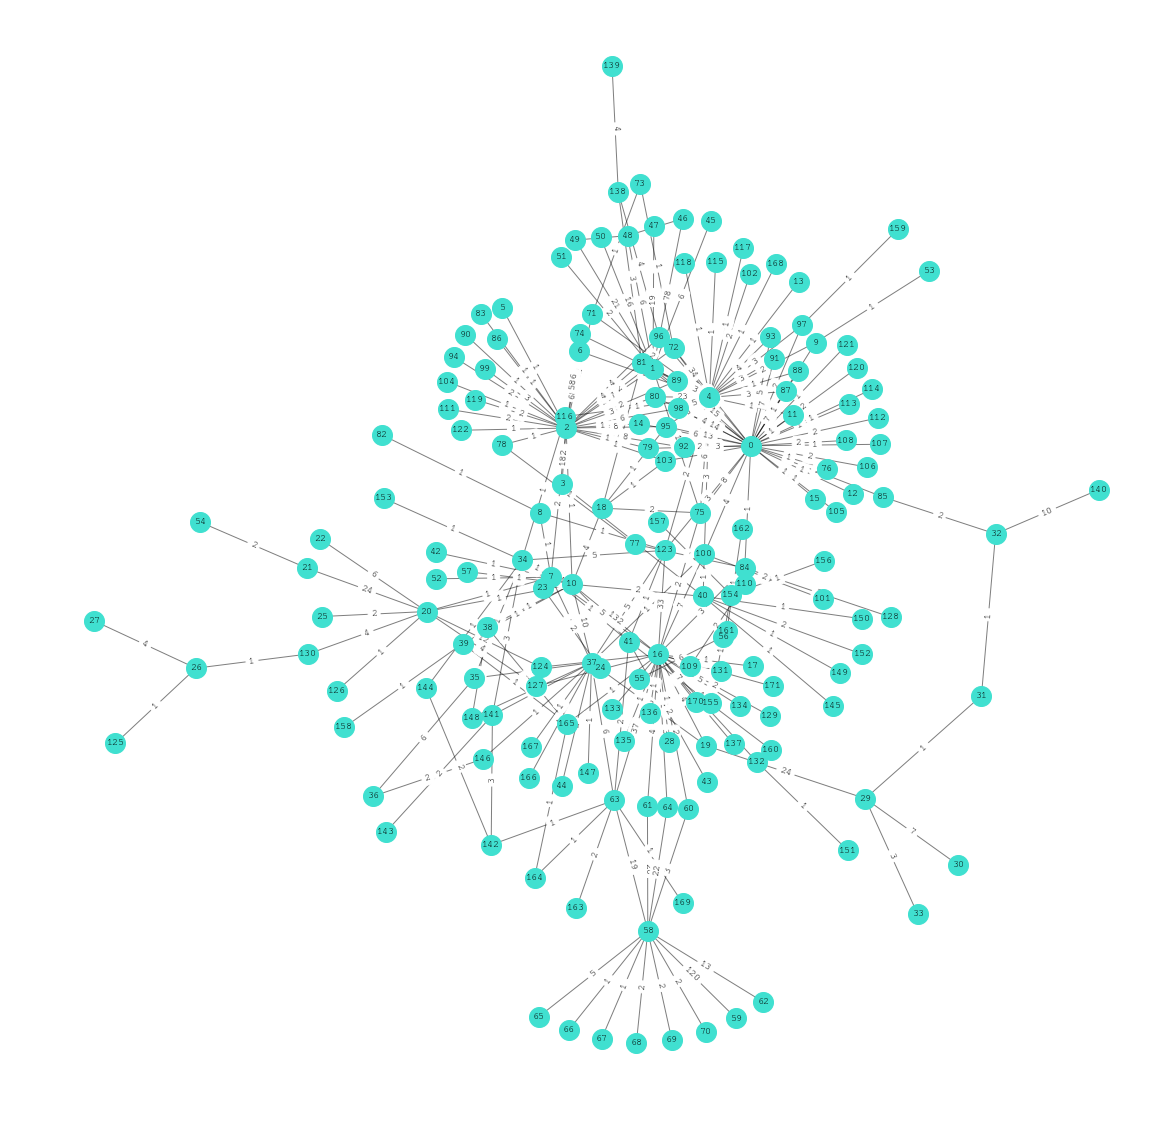

In [57]:
fig = plt.figure(figsize=(20, 20))

# nodes

nx.draw_networkx_nodes(G, pos, node_color='#40E0D0', node_size=400)

# edges
nx.draw_networkx_edges(G, pos, edgelist=edges,
                       width=1, alpha=0.5)

# labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='FreeMono')

edge_labels = nx.get_edge_attributes(G,'w')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_family='FreeMono', clip_on=False)

plt.axis('off')
#plt.show()
plt.savefig('ADV_graph_with_wiki.png', dpi=200)

In [81]:
counter_productive_forms = 0

for i in range(len(G)):
    for j in G[i]:
        if G[i][j]['w'] >= 20:
            print(i,' -> ', j, deriv_array[i].example, ' -> ', deriv_array[j].example, G[i][j]['w'])
            counter_productive_forms += 1
print(counter_productive_forms, ' productive forms')

0  ->  1 быстрый  ->  быстро 3730
0  ->  72 быстрый  ->  по-видимому 122
1  ->  0 быстро  ->  быстрый 3730
1  ->  46 быстро  ->  трудненько 78
1  ->  49 быстро  ->  ранёхонько 21
1  ->  2 быстро  ->  зябкий 147
2  ->  1 зябкий  ->  быстро 147
2  ->  3 зябкий  ->  певуче 182
2  ->  6 зябкий  ->  всячески 683
2  ->  71 зябкий  ->  по-прежнему 62
2  ->  74 зябкий  ->  по-дружески 586
3  ->  2 певуче  ->  зябкий 182
4  ->  72 озорной  ->  по-видимому 34
4  ->  80 озорной  ->  вплотную 23
6  ->  2 всячески  ->  зябкий 683
10  ->  16 пёхом  ->  день 132
16  ->  10 день  ->  пёхом 132
16  ->  63 день  ->  напрочь 37
16  ->  123 день  ->  вверх 33
19  ->  29 ночью  ->  пять 24
20  ->  21 весна  ->  весной 24
21  ->  20 весной  ->  весна 24
29  ->  19 пять  ->  ночью 24
46  ->  1 трудненько  ->  быстро 78
49  ->  1 ранёхонько  ->  быстро 21
58  ->  64 вдалеке  ->  поныне 22
58  ->  59 вдалеке  ->  невдалеке 120
58  ->  61 вдалеке  ->  засветло 20
59  ->  58 невдалеке  ->  вдалеке 120
61  ->  58